# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Conv2D,MaxPool2D, ZeroPadding2D
from keras.models import Sequential, Model
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

training.zip
SampleSubmission.csv
IdLookupTable.csv
test.zip


# Unzip Training data

In [2]:
!unzip -u ../input/facial-keypoints-detection/test.zip
!unzip -u ../input/facial-keypoints-detection/training.zip

Archive:  ../input/facial-keypoints-detection/test.zip
  inflating: test.csv                
Archive:  ../input/facial-keypoints-detection/training.zip
  inflating: training.csv            


# Loading training data

In [3]:
train_file = 'training.csv'
test_file = 'test.csv'
lookup_file = '../input/facial-keypoints-detection/IdLookupTable.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
lookup = pd.read_csv(lookup_file)

# Visualize Training Data

In [4]:
train.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


# Visualize Testing data

In [5]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [6]:
lookup.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


# Look for null values in dataset

In [7]:
train.isnull().any().value_counts()

True     28
False     3
dtype: int64

<AxesSubplot:>

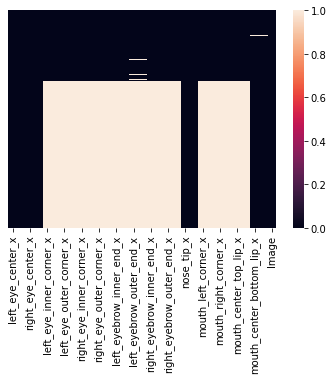

In [8]:
sns.heatmap(train.isnull(),yticklabels = False, cbar ='BuPu')

# Fill null values by "Forwad fill"

In [9]:
train.fillna(method = 'ffill',inplace = True)
train.isnull().any().value_counts()
train.shape

(7049, 31)

# Defining Function for image Pre-Processing

In [10]:
def process_img(data):
    images = []
    for idx, sample in data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

# Defining function for exctracting keypoints

In [11]:
def keypoints(data):
    keypoint = data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features


In [12]:
y_test = test.Image
y_test.head()

0    182 183 182 182 180 180 176 169 156 137 124 10...
1    76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2    177 176 174 170 169 169 168 166 166 166 161 14...
3    176 174 174 175 174 174 176 176 175 171 165 15...
4    50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
Name: Image, dtype: object

# Process dataset

In [13]:
X_train = process_img(train)
y_train = keypoints(train)

# Visualize First image of training dataset

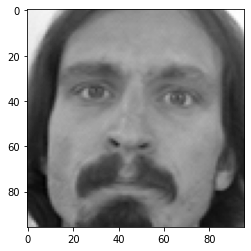

In [14]:
plt.imshow(process_img(train)[0].reshape(96,96),cmap='gray')
plt.show()

# **Modeling**

In [15]:
X_train.shape

(7049, 96, 96, 1)

# Creating an empty neural network 

In [16]:
model = Sequential([Flatten(input_shape=(96,96)),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(64, activation="relu"),
                         Dense(30)
                         ])

2023-01-12 07:49:14.385993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 07:49:14.468145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 07:49:14.468920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 07:49:14.471076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Adding hidden layers in neural network

In [17]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())

# model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())

# model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30))

model.compile(optimizer='adam',#'adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)       

# Fit the model! / Train the model!

In [18]:
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split = 0.15)

2023-01-12 07:49:17.761969: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-12 07:49:19.229833: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


24/24 [==============================] - 9s 87ms/step - loss: 472.2620 - accuracy: 0.1694 - val_loss: 2061.8945 - val_accuracy: 0.6654
Epoch 2/50
24/24 [==============================] - 1s 57ms/step - loss: 109.7401 - accuracy: 0.2322 - val_loss: 1417.6304 - val_accuracy: 0.6654
Epoch 3/50
24/24 [==============================] - 1s 57ms/step - loss: 79.5669 - accuracy: 0.2671 - val_loss: 1001.5211 - val_accuracy: 0.3384
Epoch 4/50
24/24 [==============================] - 1s 58ms/step - loss: 65.2843 - accuracy: 0.2946 - val_loss: 674.3790 - val_accuracy: 0.6522
Epoch 5/50
24/24 [==============================] - 1s 57ms/step - loss: 56.4077 - accuracy: 0.3180 - val_loss: 496.2473 - val_accuracy: 0.5142
Epoch 6/50
24/24 [==============================] - 1s 57ms/step - loss: 51.7008 - accuracy: 0.3310 - val_loss: 387.9706 - val_accuracy: 0.6569
Epoch 7/50
24/24 [==============================] - 1s 57ms/step - loss: 47.5453 - accuracy: 0.3480 - val_loss: 283.0019 - val_accuracy: 0.339

In [19]:
# try:
#     plt.plot(history.history['mae'])
#     plt.plot(history.history['val_mae'])
#     plt.title('Mean Absolute Error vs Epoch')
#     plt.ylabel('Mean Absolute Error')
#     plt.xlabel('Epochs')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
    
#     # summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
#     plt.title('Accuracy vs Epoch')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epochs')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
#     # summarize history for loss
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Loss vs Epoch')
#     plt.ylabel('Loss')
#     plt.xlabel('Epochs')
#     plt.legend(['train', 'validation'], loc='upper left')
#     plt.show()
# except Exception as e:
#     print(f"{e}: One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")


In [20]:
X_train[0][0][:10]

array([[0.93333333],
       [0.9254902 ],
       [0.92941176],
       [0.93333333],
       [0.94117647],
       [0.94117647],
       [0.9372549 ],
       [0.94509804],
       [0.94509804],
       [0.95294118]])

In [21]:
X_train = process_img(train)
y_test = process_img(test)

In [22]:
preds = model.predict(y_test)
print(preds)

[[64.79181  34.863346 28.25073  ... 67.18651  46.436386 81.34229 ]
 [65.45169  35.85035  28.387373 ... 71.83557  47.022842 81.50606 ]
 [63.469456 35.7797   29.680368 ... 70.6322   48.29614  77.62541 ]
 ...
 [66.60268  39.156338 30.82247  ... 76.63229  46.976017 75.36435 ]
 [63.050495 37.137173 28.993273 ... 73.06024  43.687393 72.46221 ]
 [65.53404  38.445408 30.03391  ... 75.02864  46.032406 77.44191 ]]


In [23]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=20, color='r')
    plt.title(title)

# Visualization of predicted keypoints

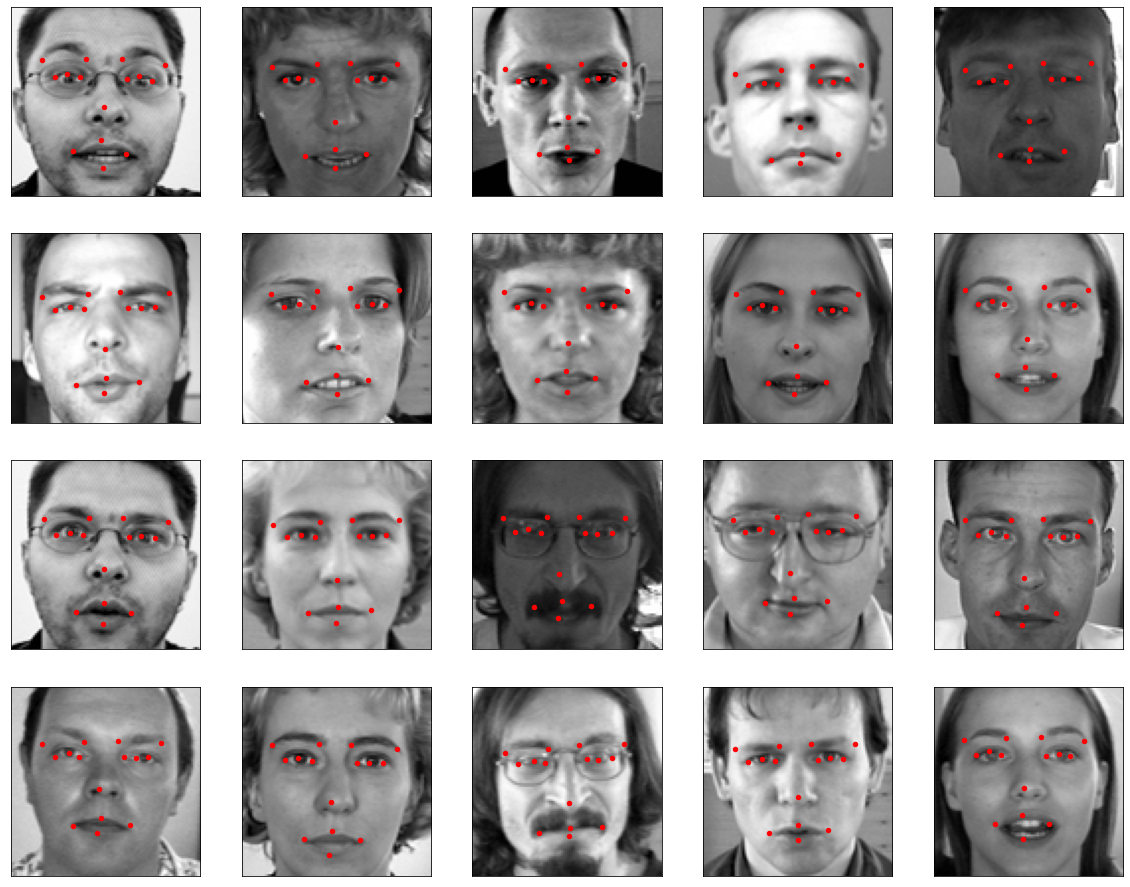

In [24]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(y_test[i], preds[i], axis, "")
plt.show()

In [25]:
lookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [26]:
print(preds[0][1])

34.863346


In [27]:
feature = list(lookup['FeatureName'])
image_ids = list(lookup['ImageId']-1)
row_ids = lookup['RowId']
pre_list = list(preds)

feature_list = []
for f in feature:
    feature_list.append(feature.index(f))

final_preds = []
for x,y in zip(image_ids, feature_list):
    final_preds.append(pre_list[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(final_preds, name = 'Location')
locations = locations.clip(0.0,96.0)

submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result

,RowId,Location
0,1,64.791809
1,2,34.863346
2,3,28.250731
3,4,33.942078
4,5,58.479607
...,...,...
27119,27120,36.926331
27120,27121,46.295815
27121,27122,61.357811
27122,27123,46.032406


In [28]:
submission_result.to_csv('submission.csv',index = False)